### Early Stopping ANN Regression

Help from https://www.youtube.com/watch?v=uLa-b3JxWAM

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [3]:
# Load Data
data = pd.read_csv('/Users/sauce/Desktop/DraftKings/ready_data/DraftKingsCleaned.csv', header = None)

# rename columns
data = data.rename(columns={0: "season", 
                        1:'game_date',
                        2: 'player',
                        3: 'team',
                        4: 'opponent',
                        5: 'venue',
                        6: 'minutes',
                        7: 'usage_rate',
                        8: 'rest',
                        9: 'avg_threes',
                        10: 'avg_reb',
                        11: 'avg_ast',
                        12: 'avg_stl',
                        13: 'avg_blk',
                        14: 'avg_tov',
                        15: 'avg_pts',
                        16: 'avg_points_vs_opp',
                        17: 'team_pace',
                        18: 'team_ast',
                        19: 'team_tov',
                        20: 'team_reb_rate',
                        21: 'team_offeff',
                        22: 'team_defeff',
                        23: 'opp_pace',
                        24: 'opp_ast',
                        25: 'opp_tov',
                        26: 'opp_reb_rate',
                        27: 'opp_offeff',
                        28: 'opp_defeff',
                        29: 'opp_pos_avg',
                        30: 'salary',
                        31: 'fantasy_points',
                       })

# Avg 10 data
data["game_date"] = pd.to_datetime(data.game_date)
data.set_index('game_date', inplace=True)
data.sort_index(inplace=True)
df_rolling = data.groupby(['player']).rolling(10).mean().rename(columns={'season':'season1', 'player':'player1'}).reset_index()
data = data.reset_index()
df_rolling = df_rolling.drop(columns=['player'])
df_rolling = df_rolling.rename(columns = {'season1': 'season', 'player1': 'player'})
data = pd.merge(data, df_rolling, on=['player', 'season', 'game_date'], left_index= True , suffixes=['', '_AVG10'])

# Avg 3 data
data["game_date"] = pd.to_datetime(data.game_date)
data.set_index('game_date', inplace=True)
data.sort_index(inplace=True)
df_rolling = data.groupby(['player']).rolling(3).mean().rename(columns={'season':'season1', 'player':'player1'}).reset_index()
data = data.reset_index()
df_rolling = df_rolling.drop(columns=['player'])
df_rolling = df_rolling.rename(columns = {'season1': 'season', 'player1': 'player'})
df = pd.merge(data, df_rolling, on=['player', 'season', 'game_date'], left_index= True , suffixes=['', '_AVG3'])

# Drop useless features
df = df.drop(columns=['team_AVG10','opponent_AVG10','venue_AVG10','rest_AVG10',
                      'avg_threes_AVG10','avg_reb_AVG10','avg_ast_AVG10','avg_stl_AVG10',
                      'avg_blk_AVG10','avg_tov_AVG10','avg_pts_AVG10','avg_points_vs_opp_AVG10',
                      'team_pace_AVG10','team_ast_AVG10','team_tov_AVG10','team_reb_rate_AVG10',
                      'team_defeff_AVG10','opp_pace_AVG10','opp_ast_AVG10','opp_tov_AVG10',
                      'opp_reb_rate_AVG10','opp_offeff_AVG10','salary_AVG10',
                      'team_AVG3', 'opponent_AVG3', 'venue_AVG3','rest_AVG3',
                      'avg_threes_AVG3', 'avg_reb_AVG3','avg_ast_AVG3', 'avg_stl_AVG3', 
                      'avg_blk_AVG3', 'avg_tov_AVG3','avg_pts_AVG3', 
                      'avg_points_vs_opp_AVG3', 'team_pace_AVG3','team_ast_AVG3', 
                      'team_tov_AVG3', 'team_reb_rate_AVG3','team_defeff_AVG3', 
                      'opp_pace_AVG3','opp_ast_AVG3', 'opp_tov_AVG3', 'opp_reb_rate_AVG3',
                      'opp_offeff_AVG3', 'opp_pos_avg_AVG3','salary_AVG3',
                      'team_AVG10_AVG3','opponent_AVG10_AVG3', 'venue_AVG10_AVG3', 
                      'minutes_AVG10_AVG3','usage_rate_AVG10_AVG3', 'rest_AVG10_AVG3',
                      'avg_threes_AVG10_AVG3', 'avg_reb_AVG10_AVG3',
                      'avg_ast_AVG10_AVG3', 'avg_stl_AVG10_AVG3', 'avg_blk_AVG10_AVG3',
                      'avg_tov_AVG10_AVG3', 'avg_pts_AVG10_AVG3',
                      'avg_points_vs_opp_AVG10_AVG3', 'team_pace_AVG10_AVG3',
                      'team_ast_AVG10_AVG3', 'team_tov_AVG10_AVG3',
                      'team_reb_rate_AVG10_AVG3', 'team_offeff_AVG10_AVG3',
                      'team_defeff_AVG10_AVG3', 'opp_pace_AVG10_AVG3',
                      'opp_ast_AVG10_AVG3', 'opp_tov_AVG10_AVG3',
                      'opp_reb_rate_AVG10_AVG3', 'opp_offeff_AVG10_AVG3',
                      'opp_defeff_AVG10_AVG3', 'opp_pos_avg_AVG10_AVG3',
                      'salary_AVG10_AVG3', 'fantasy_points_AVG10_AVG3'])

# Fill NAs
df['fantasy_points_AVG3'] = df['fantasy_points_AVG3'].fillna(df.groupby(['player', 'season'])['fantasy_points'].transform('mean'))
df['opp_defeff_AVG3'] = df['opp_defeff_AVG3'].fillna(df.groupby(['opponent', 'season'])['opp_defeff'].transform('mean'))
df['team_offeff_AVG3'] = df['team_offeff_AVG3'].fillna(df.groupby(['team', 'season'])['team_offeff'].transform('mean'))
df['usage_rate_AVG3'] = df['usage_rate_AVG3'].fillna(df.groupby(['player', 'season'])['usage_rate'].transform('mean'))
df['fantasy_points_AVG10'] = df['fantasy_points_AVG10'].fillna(df.groupby(['player', 'season'])['fantasy_points'].transform('mean'))
df['minutes_AVG3'] = df['minutes_AVG3'].fillna(df.groupby(['player', 'season'])['minutes'].transform('mean'))
df['opp_pos_avg_AVG10'] = df['opp_pos_avg_AVG10'].fillna(df.groupby(['opponent', 'season'])['opp_pos_avg'].transform('mean'))
df['opp_defeff_AVG10'] = df['opp_defeff_AVG10'].fillna(df.groupby(['opponent', 'season'])['opp_defeff'].transform('mean'))
df['team_offeff_AVG10'] = df['team_offeff_AVG10'].fillna(df.groupby(['team', 'season'])['team_offeff'].transform('mean'))
df['usage_rate_AVG10'] = df['usage_rate_AVG10'].fillna(df.groupby(['player', 'season'])['usage_rate'].transform('mean'))
df['minutes_AVG10'] = df['minutes_AVG10'].fillna(df.groupby(['player', 'season'])['minutes'].transform('mean'))

# Drop non predictive columns 
df2 = df.drop(columns=['game_date', 'season', 'player', 'team', 'opponent',
                     'minutes', 'usage_rate', 'salary'])
# Encode Dummies
df2 = pd.get_dummies(df2, columns=['venue', 'rest'], drop_first=True)

# Grab Target Variable and remove it from data.
y = df2['fantasy_points']
X = df2.drop(columns = ['fantasy_points'])

# Split data into train and test sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Scale data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()


Epoch 00001: val_loss improved from inf to 50.65386, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00002: val_loss improved from 50.65386 to 38.03859, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00003: val_loss improved from 38.03859 to 35.90383, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00004: val_loss improved from 35.90383 to 35.04736, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss improved from 35.04736 to 34.63107, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00007: val_loss improved from 34.63107 to 34.36121, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 34.36121 to 34.25102, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011:

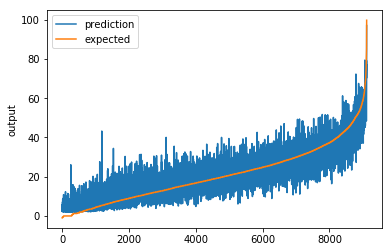

In [43]:
from keras import optimizers
from keras.layers import Dropout

optimizer=optimizers.SGD(lr=1e-4)


model_drop = Sequential()
model_drop.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model_drop.add(Dropout(0.2))
model_drop.add(Dense(20, kernel_initializer='normal', activation='relu')) 
model_drop.add(Dense(1, kernel_initializer='normal'))
model_drop.compile(loss='mean_squared_error', optimizer = optimizer)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="/Users/sauce/Desktop/DraftKings/best_weights.hdf5", verbose = 1, save_best_only = True)
model_drop.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = [monitor, checkpointer],verbose=0,epochs = 75)

pred = model_drop.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

chart_regression(pred.flatten(), y_test)


Epoch 00001: val_loss improved from inf to 35.78214, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00002: val_loss improved from 35.78214 to 35.59816, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00003: val_loss improved from 35.59816 to 35.30866, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00004: val_loss improved from 35.30866 to 35.30665, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00005: val_loss improved from 35.30665 to 34.99071, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00006: val_loss improved from 34.99071 to 34.80843, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 34.80843 to 34.74360, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011:

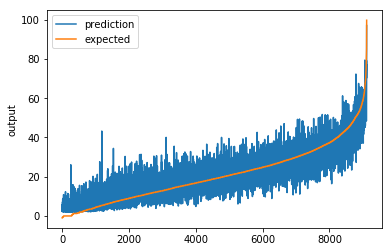

In [58]:
from keras.layers.normalization import BatchNormalization
model_drop = Sequential()
model_drop.add(Dense(60, input_dim=41, activation='relu'))
model_drop.add(BatchNormalization())
model_drop.add(Dense(1))
model_drop.compile(loss='mean_squared_error', optimizer = 'adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="/Users/sauce/Desktop/DraftKings/best_weights.hdf5", verbose = 1, save_best_only = True)
model_drop.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = [monitor, checkpointer],verbose=0,epochs = 75)

pred2 = model_drop.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

chart_regression(pred.flatten(), y_test)


Epoch 00001: val_loss improved from inf to 34.64479, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss improved from 34.64479 to 34.57100, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss improved from 34.57100 to 34.51052, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss improved from 34.51052 to 34.32731, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00013: val_loss improved from 34.32731 to 34.19548, saving model to /Users/sauce/Desktop/DraftKings/best_weights.hdf5

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did no

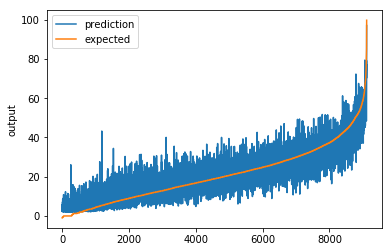

In [59]:
from keras.layers.normalization import BatchNormalization
model_drop = Sequential()
model_drop.add(Dense(41, input_dim=41))
model_drop.add(Dense(1))
model_drop.compile(loss='mean_squared_error', optimizer = 'adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="/Users/sauce/Desktop/DraftKings/best_weights.hdf5", verbose = 1, save_best_only = True)
model_drop.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = [monitor, checkpointer],verbose=0,epochs = 75)

pred2 = model_drop.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

chart_regression(pred.flatten(), y_test)